### Tool Binding

[OpenAI Function calling](https://platform.openai.com/docs/guides/function-calling?api-mode=responses&example=get-weather) 참고
- OpenAI에서 제공하는 LLM은 함수를 호출해야 할 때를 감지한 후 함수를 호출하기 위한 인수가 포함된 JSON을 출력하도록 파인튜닝되어 있음

In [2]:
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm.invoke("오늘 서울 날씨가 어때?")

AIMessage(content='죄송하지만, 실시간 날씨 정보를 제공할 수는 없습니다. 서울의 날씨를 확인하려면 기상청 웹사이트나 날씨 앱을 이용해 보시기 바랍니다. 도움이 필요하시면 다른 질문 해주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 15, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BNzX5SlnSCh7ogbhHMhKQWeFrKMB1', 'finish_reason': 'stop', 'logprobs': None}, id='run-7940ffa0-92f9-4e1d-85e8-c198ead27be8-0', usage_metadata={'input_tokens': 15, 'output_tokens': 50, 'total_tokens': 65, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

> LLM이 도구를 실행해주지는 않는다.

- 도구를 바인딩하고 모델을 호출하면, 답변을 위해 적절한 함수명과 params를 반환 

In [3]:
@tool
def get_weather(location: str) -> str:
    """Get the current weather in a given location"""
    return "오늘 서울 날씨는 맑아요"


tools = [get_weather]

llm_with_tools = llm.bind_tools(tools)

response = llm_with_tools.invoke("오늘 서울 날씨가 어때?")

print(response.tool_calls)

[{'name': 'get_weather', 'args': {'location': '서울'}, 'id': 'call_wRaeDFNPGWHKRZ8p2b3TMgHY', 'type': 'tool_call'}]


In [4]:
toolbox = {"get_weather": get_weather}

tool_call = response.tool_calls[0]
tool_name = tool_call["name"]
tool_args = tool_call["args"]

result = toolbox[tool_name].invoke(tool_args)
print(result)

오늘 서울 날씨는 맑아요


### 1. Tranditional RAG

1. 벡터 DB 생성
    - 문서를 parsing -> chunking -> embedding -> saving on vector DB

In [7]:
import os
import warnings

from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pathlib import Path

warnings.filterwarnings("ignore")


DATA_PATH = Path("data")
DB_PATH = Path("vector_store")
PERSISTANT_DIRECTORY = DB_PATH

os.makedirs(PERSISTANT_DIRECTORY, exist_ok=True)

loader = PyMuPDFLoader(DATA_PATH / "ai_brief.pdf")
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=200)

documents = loader.load()
chunks = splitter.split_documents(documents)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

if os.path.exists(PERSISTANT_DIRECTORY) and any(os.listdir(PERSISTANT_DIRECTORY)):
    print(f"Loading existing vector store: {PERSISTANT_DIRECTORY}")
    vector_store = Chroma(
        persist_directory=str(PERSISTANT_DIRECTORY),
        embedding_function=embeddings,
        collection_name="ai_trends",
    )
else:
    vector_store = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        collection_name="ai_trends",
        persist_directory=str(PERSISTANT_DIRECTORY),
    )

Loading existing vector store: vector_store


- Search

In [38]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

def format_docs(docs):
    result = []
    for i, doc in enumerate(docs):
        res = f"### 결과 {i+1}. Page : {doc.metadata['page']+1}\n"
        res += doc.page_content
        result.append(res)
    return "\n\n=========================\n\n".join(result)


query = "젬마 3의 버전에는 어떤 것들이 있나요?"

result = retriever.invoke(query)
context = format_docs(result)

print(context[:200])


### 결과 1. Page : 9
정책･법제
기업･산업
기술･연구
인력･교육
7
구글, 단일 GPU로 구동 가능한 오픈소스 AI 모델 ‘젬마 3’ 공개
n 구글이 휴대 단말에서 단일 GPU나 TPU로 구동할 수 있는 오픈소스 AI 모델 ‘젬마 3’를 매개변수 
1B, 4B, 12B, 27B의 4개 버전으로 공개
n 구글에 따르면 젬마 3는 챗봇 아레나의 인


### 1. Tranditional RAG

In [39]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
ANSWER IN KOREAN. Be sure to cite the source page in your answer.
Question: {question} 
Context: {context} 
Answer:"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

chain = (
    {"question": RunnablePassthrough(), "context": retriever | format_docs}
    | prompt 
    | llm 
    | StrOutputParser()
    )

# chain.invoke({"question": query, "context": context})

In [40]:
query = "젬마 3의 버전에는 어떤 것들이 있나요?"
print(chain.invoke(query))

젬마 3는 매개변수 1B, 4B, 12B, 27B의 4개 버전으로 제공됩니다. 이 모델은 단일 GPU나 TPU에서 실행할 수 있도록 설계되었습니다. (출처: 페이지 9)


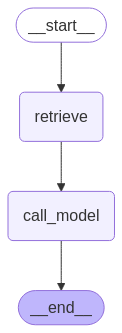

In [50]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    messages: Annotated[list, add_messages]
    docs: Annotated[str, "Search Results"]


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
rag_chain = (
    prompt 
    | llm 
)

def retrieve(state: State):
    query = state["messages"][0].content
    docs = retriever.invoke(query)
    return {"docs": format_docs(docs)}


def call_model(state: State):
    question = state["messages"][0].content
    context = state["docs"]
    response = rag_chain.invoke({"question": question, "context": context})
    return {"messages": [response]}


flow = StateGraph(State)

flow.add_node("retrieve", retrieve)
flow.add_node("call_model", call_model)

flow.add_edge(START, "retrieve")

flow.add_edge("retrieve", "call_model")
flow.add_edge("call_model", END)

memory = MemorySaver()

graph = flow.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
inputs = {"messages": [("user", "젬마 3의 버전에는 어떤 것들이 있나요?")]}
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(inputs, config=config, stream_mode="updates")

for event in events:
    for k, v in event.items():
        if "messages" in v:
            print(v["messages"][-1].pretty_print())
        else:
            print(f"{k}: {v['docs']}")




retrieve: ### 결과 1. Page : 9
정책･법제
기업･산업
기술･연구
인력･교육
7
구글, 단일 GPU로 구동 가능한 오픈소스 AI 모델 ‘젬마 3’ 공개
n 구글이 휴대 단말에서 단일 GPU나 TPU로 구동할 수 있는 오픈소스 AI 모델 ‘젬마 3’를 매개변수 
1B, 4B, 12B, 27B의 4개 버전으로 공개
n 구글에 따르면 젬마 3는 챗봇 아레나의 인간 선호도 평가에서 라마3-405B, 딥시크-V3, o3-
미니를 능가하는 것으로 나타나 크기 대비 최고의 성능을 발휘 
KEY Contents
£ 젬마 3, 텍스트와 시각적 추론 및 최대 128K 토큰의 컨텍스트 창 지원
n 구글(Google)이 2024년 3월 12일 ‘제미나이(Gemini) 2.0’ 모델 아키텍처 기반의 경량 오픈소스 
AI 모델 ‘젬마 3(Gemma 3)’를 공개
∙스마트폰과 노트북 같은 단말에서 단일 GPU나 TPU*로 실행할 수 있는 젬마 3는 매개변수 1B, 4B, 12B,


### 결과 2. Page : 9
컨텍스트 창 및 작업 자동화와 에이전트 구축을 위한 함수 호출 기능과 구조화된 출력을 제공하며, 양자화* 
버전을 통해 모델 크기와 컴퓨팅 요구사항을 줄이면서 높은 정확도를 유지
* 모델의 매개변수를 저장하는 데 필요한 비트 수를 줄여 모델 크기를 압축하고 연산 속도를 높이는 기술
∙구글은 젬마 3가 챗봇 아레나(Chatbot Arena)* 인간 선호도 평가에서 1338점으로 매개변수가 훨씬 큰 
모델인 라마3-405B(1269점), 딥시크-V3(1318점), o3-mini(1304점)를 능가했다는 점에서 크기 대비 
최고의 성능을 발휘했다고 주장
* 사용자 선호도를 통해 AI 모델을 평가하는 오픈소스 플랫폼
 <젬마 3와 주요 AI 모델의 챗봇 아레나 점수 비교>
n 구글은 젬마 3에 대한 광범위한 데이터 거버넌스 및 미세조정, 벤치마크 평가를 통해 안전성을 높이는 한편, 
젬마 3를 기반으로 이미지 안전성을 검사하는 솔루션 ‘쉴드젬마(ShieldGemm

## Tool로 줘보기

In [66]:
# LangChain 버전
from langchain_core.tools import tool

@tool
def retrieve_ai_trends(query: str) -> str:
    """Retrieve the latest trends in AI. If your question is related to AI trends, use this tool. The query must be in Korean."""
    docs = retriever.invoke(query)
    return format_docs(docs)


@tool
def get_weather(location: str) -> str:
    """Provides the weather for a given location. The location must be in Korean."""
    if location == "서울":
        return "오늘 서울 날씨는 맑아요"
    else:
        return f"오늘 {location}은 바람이 심하게 불고 있습니다.."

tools = [retrieve_ai_trends, get_weather]

llm_with_tools = llm.bind_tools(tools)

response = llm_with_tools.invoke("젬마 3의 버전에는 어떤 것들이 있나요?")
print(response.tool_calls)

response = llm_with_tools.invoke("오늘 서울의 날씨는 어떤가요?")
print(response.tool_calls)

[{'name': 'retrieve_ai_trends', 'args': {'query': '젬마 3 버전'}, 'id': 'call_tCu0m3zntFdJkDOXHf4LKS1n', 'type': 'tool_call'}]
[{'name': 'get_weather', 'args': {'location': '서울'}, 'id': 'call_2TKx0Drklj8x0QhjhOQjGQTS', 'type': 'tool_call'}]


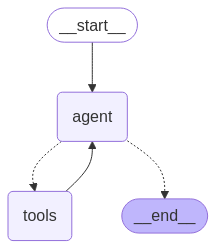

In [68]:
# LangGraph 버전
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

# 도구 정의
tools = [retrieve_ai_trends, get_weather]
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

def agent(state: State):
    query = state["messages"][0].content
    response = llm_with_tools.invoke(query)
    return {"messages": [response]}


tool_node = ToolNode(tools=tools)


flow = StateGraph(State)
flow.add_node("agent", agent)
flow.add_node("tools", tool_node)

flow.add_edge(START, "agent")
flow.add_edge("tools", "agent")

flow.add_conditional_edges(
    "agent",
    tools_condition
)

memory = MemorySaver()
graph = flow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))